# Preprocessing

### Import packages

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from surprise import Dataset, Reader
from surprise import SVD, SVDpp, KNNBaseline
from surprise.model_selection import cross_validate
from collections import defaultdict
import os
from surprise import dump
from functools import reduce
from sklearn.model_selection import train_test_split

### Load data and manipulate it for the upcoming modeling:
- Since every pair of (userId, movieId) is unique and we only need user ID, movie ID and rating for our analysis purpose, we can drop timestamp column.
- We split the data into training data and test data while making sure that every user exist in our training and test dataset.

In [41]:
ratings=pd.read_csv("ratings.csv")
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [43]:
ratings = ratings.drop('timestamp', axis = 1)
# Dividing the train_users and test_users
# The percentage of training users to take. E.g 0.8 indicates 80%
split_ratio = 0.7
train_data, test_data = train_test_split(ratings, train_size = split_ratio, random_state = 42, shuffle = True, stratify = ratings['userId'])

/Users/yi-annehuang/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [44]:
print(len(train_data.userId.unique()))
print(len(test_data.userId.unique()))

610
610


# Modeling
### Our steps are as follows:
- Let our model candidates: SVD, SVD++, and KNN to fit training data using the built-in method in surprise library **build_full_trainset**
- Take the average of the actual ratings from test data as our baseline and compare it with the estimated ratings (also average) generated from the model; plotting them on the graph
- Use three fold cross validation and RMSE score to re-confirm the performance of each model and identify the winner

In [42]:
def train(data,algorithm):
    algo=algorithm
    return algo.fit(data.build_full_trainset()) 

In [45]:
%%time
# Take the mean of actual ratings as our prediction baseline
average_ratings = test_data.groupby('userId')['rating'].mean().reset_index(drop=False)
average_ratings.rename(columns={"rating": "average"},inplace=True)

CPU times: user 5.15 ms, sys: 2.04 ms, total: 7.19 ms
Wall time: 5.71 ms


In [51]:
%%time
test_data.loc[:,'estimated_rating'] = -1

# Create a surprise model from the training dataset and train it
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(train_data, reader)

metrics_df_lists = [average_ratings]
algorithm_names = ['SVD', 'SVDpp', 'KNNBaseline']
# About baseline: http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf
algorithm_functions = [SVD(), SVDpp(), KNNBaseline(sim_options = {'name': 'cosine'}, bsl_options = {'method': 'sgd', 'learning_rate': .00005})]

for index, algorithm in enumerate(algorithm_functions):
    algorithm_name = algorithm_names[index] 
    algo = train(data, algorithm)    
    # Predicting the estimated_rating for each user and movie in test data
    for user, df in test_data.groupby('userId'):
        for index, row in df.iterrows():
            movie_id = row['movieId']
            test_data.loc[index, 'estimated_rating'] = algo.predict(uid = user, iid = movie_id).est

    # take the mean of the estimated ratings
    recommender_system_ratings = test_data.groupby('userId')['estimated_rating'].mean().reset_index(drop=False)
    recommender_system_ratings.rename(columns={'estimated_rating': algorithm_name}, inplace=True)
    metrics_df_lists.append(recommender_system_ratings)

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: user 1h 33min 36s, sys: 1min 9s, total: 1h 34min 45s
Wall time: 1h 49min 4s


In [52]:
%%time
# Combining results from all algorithms
metrics_df = reduce(lambda left, right: pd.merge(left, right, on='userId'), metrics_df_lists)
metrics_df.sort_values(by='average', inplace=True)
metrics_df.reset_index(drop=True, inplace=True)

CPU times: user 20.7 ms, sys: 20.8 ms, total: 41.4 ms
Wall time: 55.2 ms


CPU times: user 102 ms, sys: 25.5 ms, total: 128 ms
Wall time: 152 ms


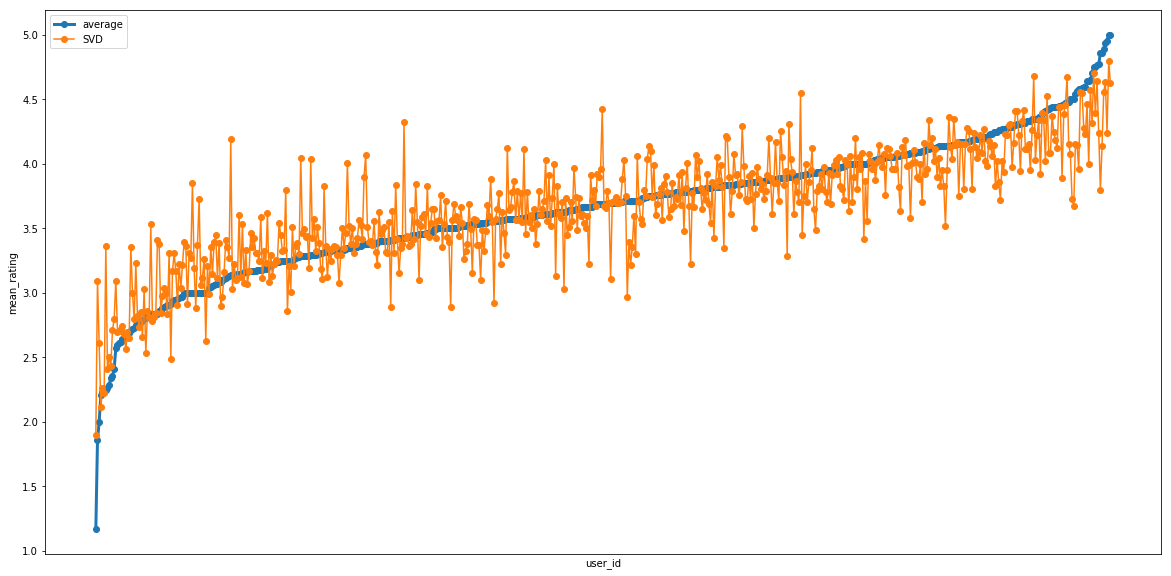

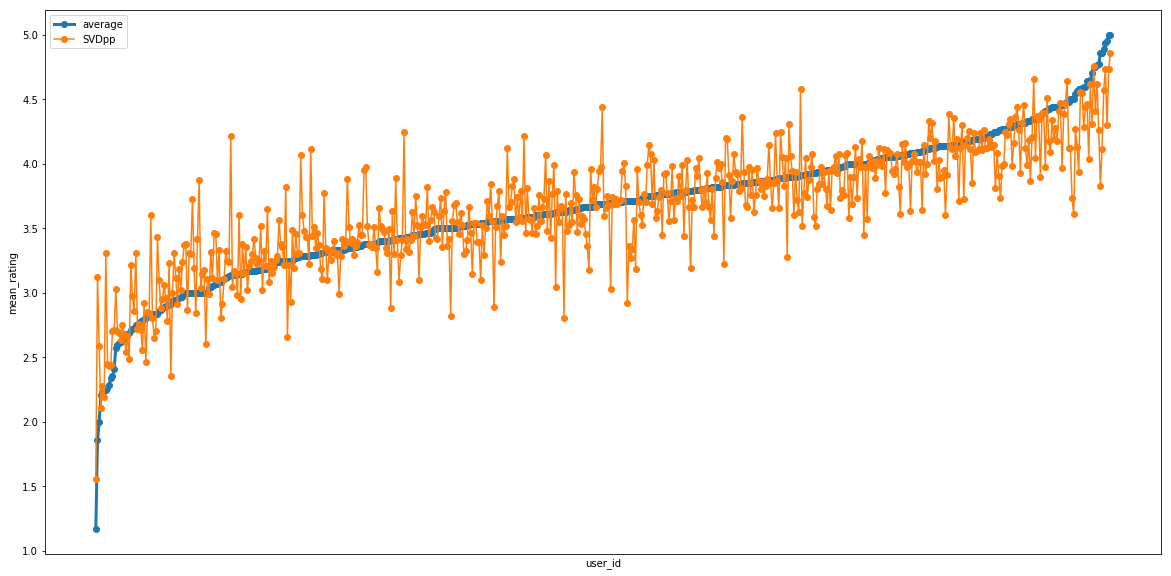

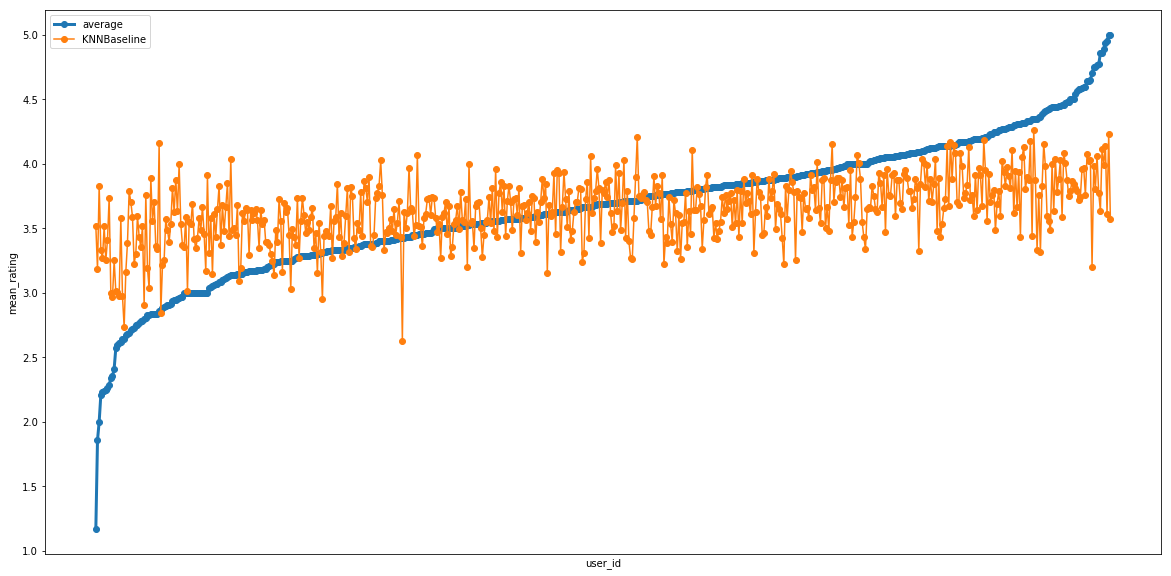

In [53]:
%%time
for algorithm in algorithm_names:
    fig = plt.figure(figsize=(20,10))
    ax  = fig.add_subplot(111)
    ax.plot(metrics_df.index, metrics_df['average'], label='average', linewidth=3, marker='o')
    ax.plot(metrics_df.index, metrics_df[algorithm], label=algorithm, marker='o')
    
    # Plot properties
    ax.legend()
    ax.set_xlabel('user_id')
    ax.set_ylabel('mean_rating')
    ax.set_xticks([],[])

#### It seems KNN has the tendency to predict ratings around 3.5 even for users who are more inclined to give higher ratings. SVD and SVD++ both show more adaptability to change their predictions based on users' behaviors/preference.
### Here we will compare their performance with RMSE scores:

In [54]:
%%time
# Plotting the mean ratings of all responses for each algorithm
avg_ratings = metrics_df.mean().to_frame(name='avg_ratings')
avg_ratings.index = avg_ratings.index.rename('Algorithm')
avg_ratings.reset_index(inplace=True)

# Benchmark
benchmark = []
# Iterate over all algorithms
for algorithm in algorithm_functions:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
summary_models = pd.DataFrame(benchmark).set_index('Algorithm')
summary_models.index = algorithm_names
summary_models = summary_models.sort_values('test_rmse')
summary_models.index = summary_models.index.rename('Algorithm')

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: user 9min 15s, sys: 3.11 s, total: 9min 18s
Wall time: 9min 33s


In [55]:
summary_models = summary_models.merge(avg_ratings.loc[1:,], how='right',on='Algorithm')
summary_models

,Algorithm,test_rmse,fit_time,test_time,avg_ratings
0,SVDpp,0.884233,179.707006,5.333150,3.653219
1,SVD,0.893880,3.484540,0.199427,3.660058
2,KNNBaseline,0.962982,0.408815,1.280196,3.642679
3,average,NaN,NaN,NaN,3.661196


#### In terms of RMSE scores, the winner model is SVD++, but it also costs a lot of time to train. SVD has competitive predictive power and more acceptable training time, while KNN with cosine similarity might not the idealest model for this dataset.